Resolved 1000 pipelines in 5.80 seconds
Average resolution time: 0.0058 seconds per pipeline
Max program length: 16


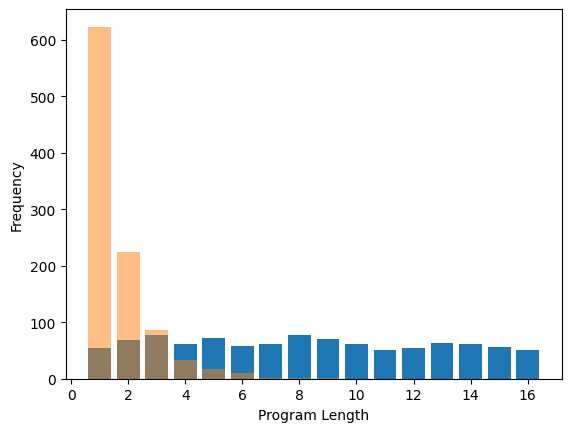

In [ ]:
from neps.space.new_space import Nosbench_space, Nosbench_space_int#, MAX_PROGRAM_LENGTH, MAX_PROGRAM_LENGTH
import neps.space.new_space.space as space
from nosbench.utils import prune_program
import pprint
import time

MAX_PROGRAM_LENGTH = 16
MAX_EPOCHS_PER_CONFIG = 20

pipeline = Nosbench_space_int(max_program_length=MAX_PROGRAM_LENGTH, max_epochs_per_config=MAX_EPOCHS_PER_CONFIG)

lines= []
shorter_lines = []
iterations = 1000
start_time = time.time()
for i in range(iterations):
    resolved_pipeline, resolution_context = space.resolve(pipeline,environment_values={"epochs":1},domain_sampler=space.RandomSampler({}))
    p = resolved_pipeline.program
    program = space.convert_operation_to_callable(p)
    lines.append(len(program))
    prune_program(program)
    shorter_lines.append(len(program))

print(f"Resolved {iterations} pipelines in {time.time() - start_time:.2f} seconds")
print(f"Average resolution time: {(time.time() - start_time) / iterations:.4f} seconds per pipeline")

import matplotlib.pyplot as plt
plt.hist(lines, bins=range(1, MAX_PROGRAM_LENGTH + 2), align='left', rwidth=0.8)
plt.hist(shorter_lines, bins=range(1, MAX_PROGRAM_LENGTH + 2), align='left', rwidth=0.8, alpha=0.5)
plt.xlabel('Program Length')
plt.ylabel('Frequency')
print(f"Max program length: {max(lines)}")


In [8]:
from nosbench.utils import prune_program
from nosbench.program import Program
from neps.space.new_space.nosbench_spaces import Nosbench_space, Nosbench_space_int
import math
import nosbench
from functools import partial
import neps
import neps.space.new_space.bracket_optimizer as new_bracket_optimizer
import torch

MAX_PROGRAM_LENGTH = 16
MAX_EPOCHS_PER_CONFIG = 20
AVAILABLE_VARIABLE_SLOTS = 11

def evaluate_pipeline(program: Program, epochs:int=1, **_) -> float:
    # benchmark = nosbench.NOSBench()
    benchmark = nosbench.ToyBenchmark()
    prune_program(program)
    objective_to_minimize = benchmark.query(program, epochs)
    assert isinstance(objective_to_minimize, float)
    objective_to_minimize = torch.inf if math.isnan(objective_to_minimize) else objective_to_minimize
    return objective_to_minimize


optimizers=[(space.RandomSearch,
            "new__RandomSearch",),
            (space.ComplexRandomSearch,
            "new__ComplexRandomSearch",),
            (partial(new_bracket_optimizer.priorband, base="successive_halving"),
                "new__priorband+successive_halving",),
            (partial(new_bracket_optimizer.priorband, base="asha"),
                "new__priorband+asha",),
            (partial(new_bracket_optimizer.priorband, base="async_hb"),
                "new__priorband+async_hb",),
            (new_bracket_optimizer.priorband,
                "new__priorband+hyperband",),
            ]


def nosbench_neps_demo(optimizer, optimizer_name):
    optimizer.__name__ = optimizer_name  # Needed by NEPS later.
    pipeline_space = Nosbench_space(max_program_length=MAX_PROGRAM_LENGTH,
                                    max_epochs_per_config=MAX_EPOCHS_PER_CONFIG,
                                    available_variable_slots=AVAILABLE_VARIABLE_SLOTS)
    pipeline_space = Nosbench_space_int(max_program_length=MAX_PROGRAM_LENGTH,
                                        max_epochs_per_config=MAX_EPOCHS_PER_CONFIG,
                                        available_variable_slots=AVAILABLE_VARIABLE_SLOTS)
    root_directory = f"results/nosbench_{optimizer.__name__}"

    print(f"Running for root directory: {root_directory}")
    neps.run(
        evaluate_pipeline=space.adjust_evaluation_pipeline_for_new_space(
            evaluate_pipeline,
            pipeline_space,
        ),
        pipeline_space=pipeline_space,
        optimizer=optimizer,
        root_directory=root_directory,
        post_run_summary=True,
        max_evaluations_total=2,
        overwrite_working_directory=True,
    )
    neps.status(root_directory, print_summary=True)

for optimizer in optimizers:
    print(f"\nRunning optimizer: {optimizer[1]}")
    nosbench_neps_demo(*optimizer)


Running optimizer: new__RandomSearch
Running for root directory: results/nosbench_new__RandomSearch
# Configs: 2

    success: 2

# Best Found (config 2):

    objective_to_minimize: 1.1162960052490234
    config: {'SAMPLING__Resolvable.program.args[0].resampled_operation.args.resampled_categorical::categorical__3': 2, 'SAMPLING__Resolvable.program.args[0].resampled_operation.kwargs{store}.resampled_integer::integer__9_20_False': 12, 'SAMPLING__Resolvable.program.args[0].resampled_operation.args[0].resampled_categorical::categorical__2': 0, 'SAMPLING__Resolvable.program.args[0].resampled_operation.args[1].resampled_categorical::categorical__3': 0, 'SAMPLING__Resolvable.program.args[0].resampled_operation.args[1].resampled_categorical.sampled_value.resampled_categorical::categorical__3': 0, 'SAMPLING__Resolvable.program.args[0].resampled_operation.args[2].resampled_categorical::categorical__3': 0, 'SAMPLING__Resolvable.program.args[0].resampled_operation.args[2].resampled_categorical.s

In [ ]:
# Load in config from yaml file in results folder
import yaml

with open("./results/nosbench_new__priorband+hyperband/configs/config_59_2/config.yaml") as stream:
    config=yaml.safe_load(stream)
    # pprint.pprint(config)

# For each key, remove the 'SAMPLING__' prefix, except for 'epochs'
for key in list(config.keys()):
    if key.startswith('SAMPLING__'):
        new_key = key[len('SAMPLING__'):]
        config[new_key] = config.pop(key)

# Collect the ENVIRONMENT__ values in a separate dictionary without the prefix
environment_values = {}
for key in list(config.keys()):
    if key.startswith('ENVIRONMENT__'):
        new_key = key[len('ENVIRONMENT__'):]
        environment_values[new_key] = config.pop(key)

resolved_pipeline, resolution_context = space.resolve(nosBench(),space.OnlyPredefinedValuesSampler(config),environment_values=environment_values)
program=space.convert_operation_to_callable(resolved_pipeline.program)
pprint.pprint(program)
prune_program(program)
print()
pprint.pprint(program)

FileNotFoundError: [Errno 2] No such file or directory: './results/nosbench_new__priorband+hyperband/configs/config_59_2/config.yaml'